In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pyvibdmc.analysis import *
from pyvibdmc.simulation_utilities import *
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
def load_training(training_name):
    """If using deb_training_every argument, read the files with this."""
    with h5py.File(training_name, 'r') as f:
        cds = f['coords'][:]
        vs = f['pots'][:]
    return cds, Constants.convert(vs, "wavenumbers", to_AU=False)


def get_ml_data(ts):
    tot_x = []
    tot_v = []
    for time in ts:
        cds, vs = load_training(f"training_0_training_{time}ts.hdf5")
        tot_x.append(cds.squeeze())
        tot_v.append(vs)
    tot_x = np.concatenate(tot_x)
    tot_v = np.concatenate(tot_v)
    return tot_x, tot_v


def pre_process_CNN(x, n):
    
    X_MIN = 0
    X_MAX = 7
    
    def dis_map(coord):
        dis_generator = lambda i,j: np.linalg.norm(coord[i]-coord[j])
        full_map = np.fromfunction(np.vectorize(dis_generator), (n,n), dtype=int)
        return np.triu(full_map)

    def normalize(x):
        return np.exp(-0.5*x)

    x = np.array([dis_map(cd) for cd in x])
    return normalize(x)


def pre_process_Dense(x, n):
    X_MIN = 0
    X_MAX = 7
    
    def dis_vec(coord):
        dis_generator = lambda i,j: np.linalg.norm(coord[i]-coord[j])
        full_map = np.fromfunction(np.vectorize(dis_generator), (n,n), dtype=int)
        vec = np.triu(full_map).flatten()
        return vec[vec != 0]

    def normalize(x):
        #return (x-X_MIN)/(X_MAX-X_MIN)
        return np.exp(-0.5*x)
    
    x = np.array([dis_vec(cd) for cd in x])
    return normalize(x)

tss = [1000,1500,2000,3000,3500,4000,4500]
train_x, train_y = get_ml_data(tss)
train_x = pre_process_CNN(train_x, 6)[:,:,:,np.newaxis]

val_set = [2500]
val_x, val_y = get_ml_data(val_set)
val_x = pre_process_CNN(val_x, 6)[:,:,:,np.newaxis]

In [4]:
def plot_result(history, model):
    fig = plt.figure(figsize=(8,6))
    ax_loss = fig.add_subplot(111)
    
    ax_loss.plot(history.history['loss'])
    ax_loss.plot(history.history['val_loss'])
    ax_loss.set_ylabel('loss')
    ax_loss.set_xlabel('epoch')
    ax_loss.legend(['train', 'test'], loc='upper right')
    
    plt.show()

In [29]:
encoder = models.Sequential()
encoder.add(layers.Input(shape=(6,6,1)))
encoder.add(layers.Conv2D(64, (2,2), activation=tf.nn.swish, padding='same'))
encoder.add(layers.MaxPooling2D((2, 2), padding='same'))
encoder.add(layers.Conv2D(64, (2,2), activation=tf.nn.swish, padding='same'))
encoder.add(layers.MaxPooling2D((2, 2), padding='same'))
encoder.add(layers.Conv2D(10, (2,2), activation=tf.nn.swish, padding='valid'))

encoder.add(layers.UpSampling2D((2, 2)))
encoder.add(layers.Conv2D(64, (2,2), activation=tf.nn.swish, padding='same'))
encoder.add(layers.UpSampling2D((2, 2)))
encoder.add(layers.Conv2D(64, (2,2), activation=tf.nn.swish, padding='valid'))
encoder.add(layers.UpSampling2D((2, 2)))
encoder.add(layers.Conv2D(1, (2,2), activation=tf.nn.swish, padding='same'))

encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 6, 6, 64)          320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 3, 64)          16448     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 1, 10)          2570      
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 2, 2, 10)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 2, 2, 64)         

In [30]:
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.005, decay_steps=100000, decay_rate=0.8)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

encoder.compile(optimizer=optimizer,
                 loss='mse',
                 metrics=[])

In [31]:
history = encoder.fit(train_x, train_x, validation_split=0.1, batch_size=128, epochs=50)

Epoch 1/50
486/486 [==============================] - 4s 9ms/step - loss: 0.0322 - val_loss: 0.0018
Epoch 2/50
486/486 [==============================] - 4s 9ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 3/50
486/486 [==============================] - 4s 9ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 4/50
486/486 [==============================] - 5s 10ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 5/50
486/486 [==============================] - 5s 9ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 6/50
486/486 [==============================] - 4s 9ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 7/50
486/486 [==============================] - 4s 8ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 8/50
486/486 [==============================] - 4s 8ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/50
486/486 [==============================] - 5s 9ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/50
486/486 [==============================] - 4s 8ms/step - loss: 0.0015 - val_loss: 0.001

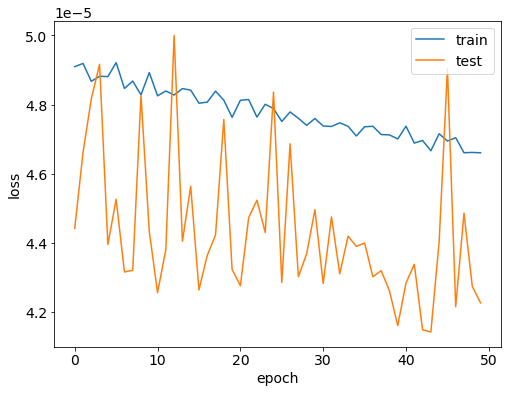

In [24]:
plot_result(history, encoder)

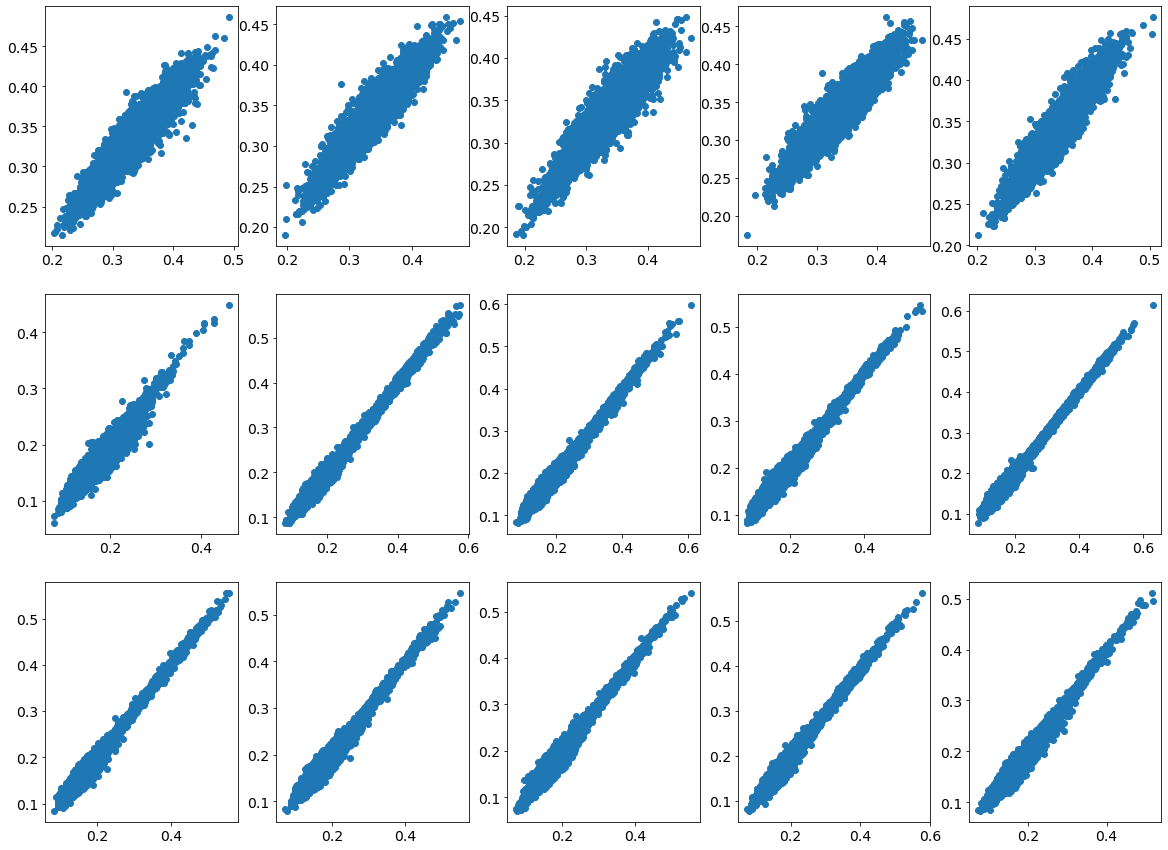

In [25]:
def plot_dis_vec(x1, x2):
    indices = [(0,1),(0,2),(0,3),(0,4),(0,5),(1,2),(1,3),(1,4),(1,5),(2,3),(2,4),(2,5),(3,4),(3,5),(4,5)]
    x1 = np.squeeze(x1)
    x2 = np.squeeze(x2)
    fig = plt.figure(figsize=(20,15))
    plots = []
    for i in range(15):
        plots.append(fig.add_subplot(3,5,i+1))
        plots[i].scatter(x1[:,indices[i][0], indices[i][1]], x2[:,indices[i][0], indices[i][1]])
    plt.show()
    
plot_dis_vec(val_x, encoder.predict(val_x))

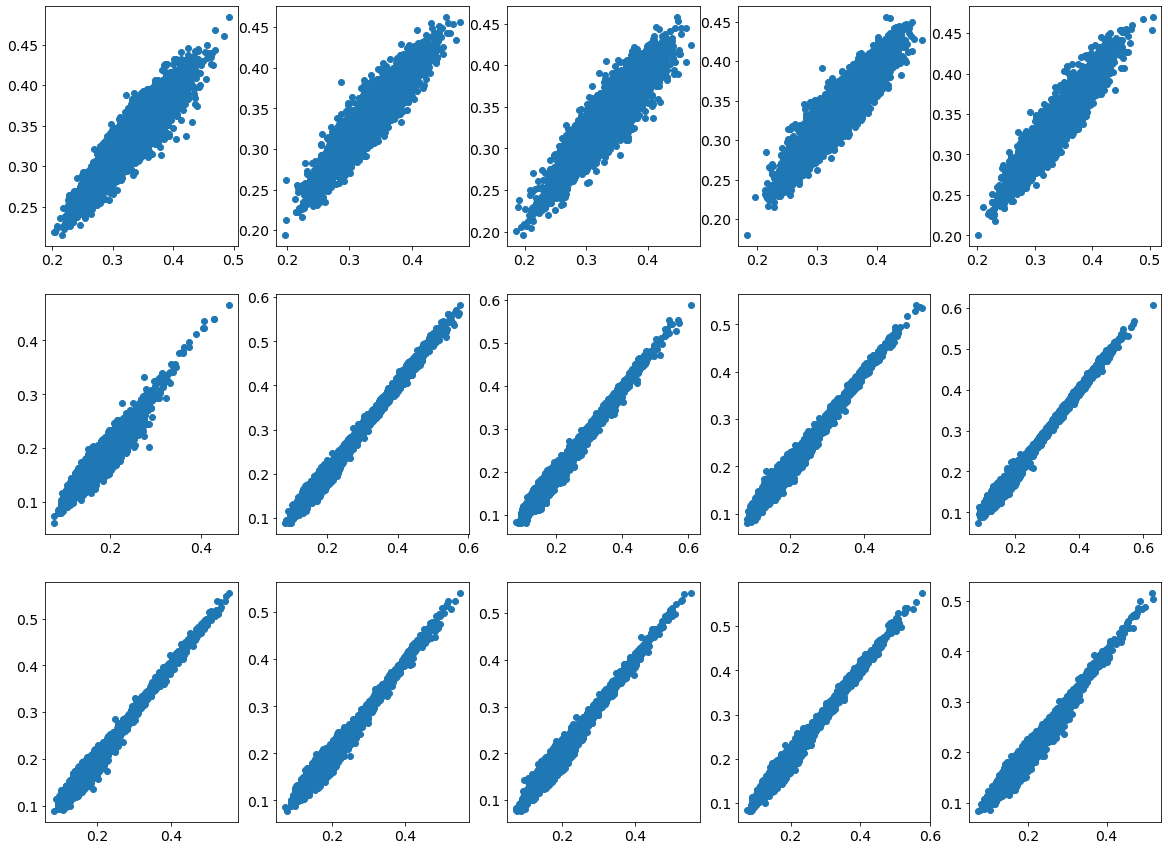

In [22]:
plot_dis_vec(val_x, encoder.predict(val_x))